In [1]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

## 2_Dataset Dataloaders

- 데이터셋 코드와 모델 훈련 코드를 서로 독립적으로 작성하여 가독성과 모듈성을 높이는 것이 좋다
- PyTorch는 두 가지 데이터 프리미티브(Data Primitives : 는 데이터 처리를 위한 기본적인 도구와 함수)를 제공한다
    - torch.utils.data.DataLoader
    - torch.utils.data.Dataset
- 위와 같은 함수들은 데이터를 불러오고 직접 구성할 때 도움을 줄 뿐만 아니라 사용자가 자신의 프로젝트에 맞게 데이터셋을 구성하는 데 유용하다


## Loading a Dataset

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor() # 데이터를 텐서로 변환
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## Iterating and Visualizing the Dataset

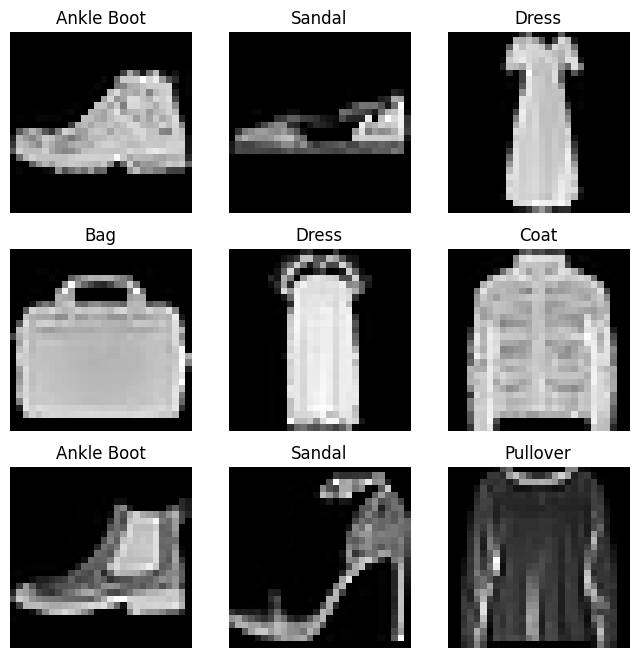

In [2]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item() #무작위 샘플을 뽑기 위해 랜덤값 생성
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Creating a Custom Dataset for your files

In [3]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):

    # __init__ 함수는 데이터셋을 초기화하는 데 필요한 정보를 입력받는다
    # annotations_file : 파일명과 라벨 정보가 저장된 CSV 파일의 경로
    # transform, target_transform은 데이터와 라벨에 적용할 전처리 함수를 나타내는 매개변수
    
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    # 주어진 인덱스 idx에 해당하는 샘플과 라벨을 반환하는 __getitem__ 메서드
    # transform, target_transform 에 지정된 전처리 함수를 실행하고 전처리된 결과를 리턴
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
    # __getitem__
    # 인덱스를 기반으로 해당 이미지의 디스크 상의 위치를 식별한다
    # read_image 함수를 사용하여 해당 이미지를 텐서로 변환한다
    # self.img_labels에 저장된 CSV 데이터에서 해당하는 라벨을 가져온다
    # 이후에 지정된 전처리 함수들을 적용하여 데이터를 변환한 뒤, 텐서 형태의 이미지와 해당하는 라벨을 튜플로 반환

- transform
    - transform에 지정된 함수들을 차례대로 적용하여 데이터를 변환한다(전처리)
    - 이미지 데이터의 크기를 조정하거나 정규화(normalization)를 수행하는 함수를 transform으로 지정하여 이미지 데이터를 모델에 입력 가능한 형태로 변환할 수 있다 
- target_transform
    - 라벨에 적용할 전처리 함수
    - 라벨을 원하는 형태로 변환하거나 원-핫 인코딩(one-hot encoding) 등의 기능을 수행할 수 있다
    - 주로 분류 작업에서 사용되며, 라벨이 숫자 형태가 아닌 다른 형태로 주어진 경우에 유용하다
    - 문자열 형태로 주어진 클래스 라벨을 숫자로 변환하거나, 클래스 라벨을 원-핫 인코딩 형태로 변환하는 함수를 target_transform으로 지정할 수 있다

## Preparing your data for training with DataLoaders

- Dataset은 데이터셋의 특징(feature)과 라벨(label)을 한 번에 하나의 샘플씩 반환하는 역할을 한다
- 딥 러닝 모델을 훈련할 때에는 일반적으로 샘플들을 "미니배치(minibatch)"로 묶어서 처리하고, 매 에폭(epoch)마다 데이터를 재섞어서 모델의 과적합(overfitting)을 줄이며, Python의 멀티프로세싱(multiprocessing)을 사용하여 데이터를 빠르게 읽어오는 것이 일반적이므로 복잡성을 추상화하고 사용자에게 쉬운 인터페이스를 제공하기 위해 DataLoader가 사용된다

- DataLoader는 이러한 기능을 쉽게 사용할 수 있도록 해주는 반복 가능한(iterable) 객체이다
- DataLoader는 Dataset 객체를 입력으로 받아 데이터셋을 미니배치로 자동으로 묶어주고, 에폭마다 데이터를 재섞어주며, 멀티프로세싱을 사용하여 데이터를 빠르게 로드하는 등의 기능을 제공한다


In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Iterate through the DataLoader

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


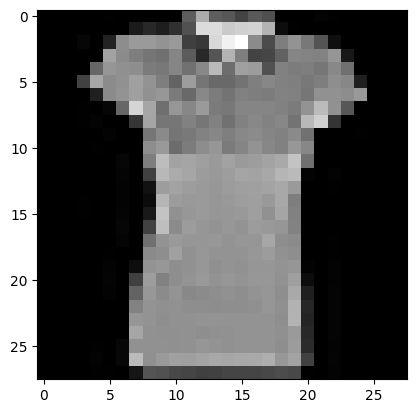

Label: 0


In [6]:
# Display image and label.
# 각각의 64개의 샘플로 된 미니배치를 만들고 그 중 첫번째 샘플을 출력
# 다시 실행하면 다음 미니배치의 첫 번째 샘플을 출력하고 모든 미니배치를 반복한 후(한 애폭이 지난 후) 랜덤으로 데이터가 섞인다(shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## reference

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html